<a href="https://www.kaggle.com/code/saibhossain/explain-diffusion-model?scriptVersionId=290518293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Diffusion Models: A Beginner-Friendly Guide

###  What Is a Diffusion Model?

- **Core idea**: Generate images by **removing noise step-by-step**.
- **Process**:
  1. Start with a clean image (e.g., a face).
  2. **Add noise gradually** until it becomes pure static.
  3. Train a model to **reverse** this process.
  4. At inference: start from **random noise** → **denoise** → generate a **new image**.

>  **Generation = noise → image**





###  Why “Diffusion”?

- Inspired by **physics**: like ink diffusing in water.
- In ML:
  - **Forward**: data → noise (destroy)
  - **Reverse**: noise → data (create)

In [3]:
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("cuda")

image = pipe("a a man stanading in middle of cyberpunk city at night, neon lights, raining").images[0]
image.save("output.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

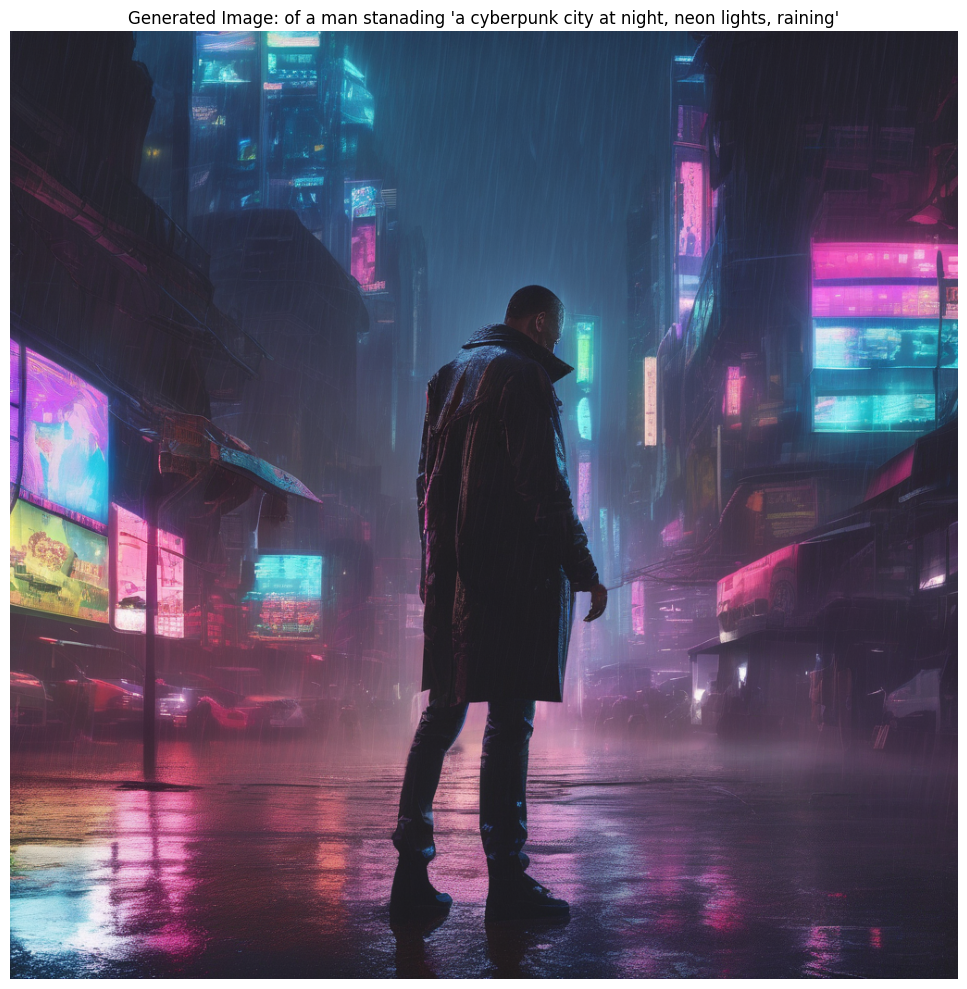

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image: of a man stanading 'a cyberpunk city at night, neon lights, raining'", fontsize=12)
plt.tight_layout()
plt.show()

# Lets Build our Own Model

## Datasets

In [4]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


## DIFFUSION UTILITIES

---

###  Training Objective (Surprisingly Simple)

- **Loss function**:
  $$
  \mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
  $$

- **In plain English**:  
  > “Make the predicted noise **as close as possible** to the actual noise.”

-  No adversarial loss  
-  No discriminator  
-  Stable and easy to train



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm

# --- 1. DIFFUSION UTILITIES (The Math) ---
class DiffusionUtils:
    def __init__(self, timesteps=1000, device="cuda"):
        self.timesteps = timesteps
        self.device = device
        
        # Define beta schedule (linear increase in noise)
        self.beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0) # Cumulative product

    def noise_images(self, x, t):
        """Adds noise to a clean image x at timestep t"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        
        # x_t = sqrt(alpha_hat) * x_0 + sqrt(1 - alpha_hat) * noise
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        """Get random timesteps for training batch"""
        return torch.randint(low=1, high=self.timesteps, size=(n,), device=self.device)

    @torch.no_grad()
    def sample(self, model, n, img_size):
        """Generates new images from pure noise"""
        print(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, img_size, img_size)).to(self.device)
            
            # Reverse loop: T -> 0
            for i in tqdm(reversed(range(1, self.timesteps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # The Algorithm to remove noise step-by-step
                # x_{t-1} = 1/sqrt(alpha) * (x_t - ((1-alpha)/sqrt(1-alpha_hat)) * predicted_noise) + sqrt(beta) * noise
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                
        model.train()
        
        # Un-normalize from [-1, 1] to [0, 1]
        x = (x.clamp(-1, 1) + 1) / 2
        return x

---

###  What Neural Network? → **U-Net**

- **Why U-Net?**
  - Captures **local details** (via skip connections)
  - Maintains **global structure** (via downsampling/upsampling)

- **Inputs**:
  - Noisy image $ x_t $
  - **Timestep embedding** (so model knows "how noisy" it is)
  - **Conditioning** (text, class)


In [6]:
# --- 2. THE ARCHITECTURE (U-Net) ---
class SelfAttention(nn.Module):
    """Helps the model understand global structure (like eyes match)"""
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        # Reshape for Attention: (Batch, Channels, Height, Width) -> (Batch, Height*Width, Channels)
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(self.ln(attention_value)) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class DoubleConv(nn.Module):
    """Basic block: Conv -> GroupNorm -> GELU -> Conv -> GroupNorm -> GELU"""
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
        # Layer to process time embedding
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        # Downsample
        x = self.maxpool_conv(x)
        # Inject Time Embedding (Broadcast to image size)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1) # Concatenate skip connection
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        
        # Input: 64x64
        self.inc = DoubleConv(c_in, 64)
        
        # Downsampling
        self.down1 = Down(64, 128)  # -> 32x32
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256) # -> 16x16
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256) # -> 8x8
        self.sa3 = SelfAttention(256, 8)

        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        # Upsampling
        self.up1 = Up(512, 128) # -> 16x16
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)  # -> 32x32
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)  # -> 64x64
        self.sa6 = SelfAttention(64, 64)
        
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """Sinusoidal Positional Encoding for Timesteps"""
        # FIX: Use t.device to support DataParallel (Multi-GPU)
        device = t.device 
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        # Flatten timestep t to basic (Batch,) shape if needed
        t = t.unsqueeze(-1).type(torch.float)
        # Calculate time embeddings
        t = self.pos_encoding(t, self.time_dim)
        
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

## CONFIGURATION

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import os
import random
from PIL import Image
from tqdm import tqdm



# --- CONFIGURATION ---
DATASET_PATH = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
OUTPUT_DIR = "./ddpm_faces_output"
CHECKPOINT_DIR = "./ddpm_checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 64        # 64x64 is standard for "from scratch" learning.
BATCH_SIZE = 14      # Reduced from 128 to 64 (32 per GPU) to prevent OOM
TIMESTEPS = 1000     # How many steps to destroy/create the image
LR = 3e-4            # Learning Rate
EPOCHS = 50          # Number of training epochs
LOG_INTERVAL = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on {DEVICE}")

In [13]:
# --- 1. DATASET LOADING ---
class SimpleImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.images = []
        # Recursively find all images
        print(f"Scanning {root}...")
        for dirpath, _, filenames in os.walk(root):
            for f in filenames:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(dirpath, f))
        # Limit for debugging if needed, or remove slice to use full dataset
        # self.images = self.images[:10000] 
        print(f"Found {len(self.images)} images.")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Robust loading loop (tries random image if one is corrupt)
        while True:
            try:
                img_path = self.images[idx]
                img = Image.open(img_path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                return img
            except:
                idx = random.randint(0, len(self.images) - 1)

# Transformations: Resize to square and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) 
])

dataset = SimpleImageDataset(DATASET_PATH, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(len(dataset))

Scanning /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba...
Found 202599 images.
202599


In [34]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SimpleImageDataset(Dataset):
    def __init__(self, root, transform=None, max_samples=None):
        self.transform = transform
        self.images = []
        print(f"Scanning {root}...")
        for dirpath, _, filenames in os.walk(root):
            for f in filenames:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(dirpath, f))
        
        # Optionally limit the dataset size
        if max_samples is not None:
            self.images = self.images[:max_samples]  # or use random.sample for randomness

        print(f"Found {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        while True:
            try:
                img_path = self.images[idx]
                img = Image.open(img_path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                return img
            except Exception as e:
                # Optionally log error
                idx = random.randint(0, len(self.images) - 1)

# Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalizes to [-1, 1]
])

# Create dataset with only 10,000 samples
dataset = SimpleImageDataset(DATASET_PATH, transform=transform, max_samples=50000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Using {len(dataset)} samples.")

Scanning /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba...
Found 50000 images.
Using 50000 samples.


---
##  Forward Diffusion (No Learning!)

- **Goal**: Destroy the image in a **fixed, known way**.
- Let:
  - $ x_0 $ = original image  
  - $ x_1, x_2, ..., x_T $ = increasingly noisy versions  
  - $ T \approx 1000 $ steps

- **Update rule**:
  $$
  x_t = \sqrt{1 - \beta_t} \, x_{t-1} + \sqrt{\beta_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
  $$
  where $ \beta_t $ is a small noise schedule.



>  **No neural net here**—this process is **deterministic and pre-defined**.

In [21]:
def visualize_forward_diffusion():
    """
    Displays the original image and its noisy versions side by side
    when the function is called.
    """
    print("\n--- PHASE 1: Visualizing Forward Diffusion (Destruction) ---")
    
    # 1. Load one image
    images = next(iter(dataloader))                 # [B, 3, H, W]
    x0 = images[0].unsqueeze(0).to(DEVICE)          # [1, 3, H, W]

    # Denormalize original for visualization
    x0_vis = (x0.clamp(-1, 1) + 1) / 2

    # 2. Diffusion utility
    diffusion = DiffusionUtils(TIMESTEPS, device=DEVICE)

    # 3. Timesteps to visualize
    visualization_steps = [0, 100, 250, 500, 750, 999]
    images_to_plot = [x0_vis]

    print(f"Generating noise steps: {visualization_steps}")

    for step in visualization_steps:
        t = torch.tensor([step]).to(DEVICE).long()
        x_t, _ = diffusion.noise_images(x0, t)

        x_t_vis = (x_t.clamp(-1, 1) + 1) / 2
        images_to_plot.append(x_t_vis)

    # 4. Plot side by side
    num_images = len(images_to_plot)
    plt.figure(figsize=(2.5 * num_images, 3))

    for i, img in enumerate(images_to_plot):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0].permute(1, 2, 0).cpu())
        plt.axis("off")
        if i == 0:
            plt.title("Original")
        else:
            plt.title(f"t = {visualization_steps[i - 1]}")

    plt.tight_layout()
    plt.show()



--- PHASE 1: Visualizing Forward Diffusion (Destruction) ---
Generating noise steps: [0, 100, 250, 500, 750, 999]


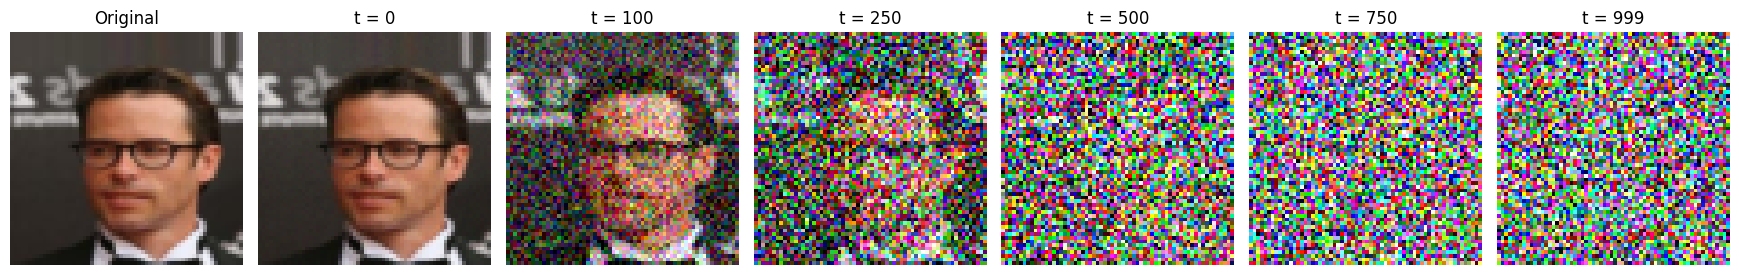

In [22]:
visualize_forward_diffusion()

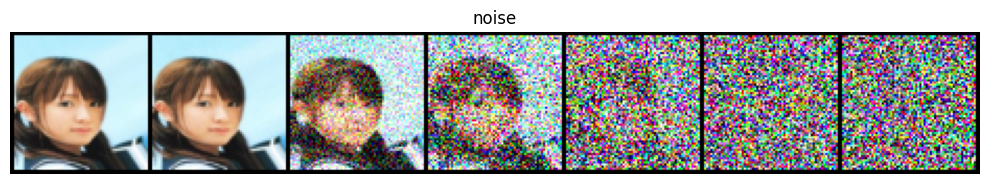

In [24]:
import matplotlib.pyplot as plt
from PIL import Image

# Load and display
img = Image.open("/kaggle/working/ddpm_faces_output/forward_process_demo.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("noise", fontsize=12)
plt.tight_layout()
plt.show()





---
## Reverse Diffusion

###  Reverse Diffusion (Where Learning Happens)

- **Challenge**: Reverse the noise process **without knowing the true clean image**.
- **Solution**: Train a neural network to **predict the noise** added at step $ t $:
  $$
  \epsilon_\theta(x_t, t)
  $$

- **How generation works**:
  1. Start with $ x_T \sim \mathcal{N}(0, I) $
  2. Predict noise → remove it → get $ x_{T-1} $
  3. Repeat until $ x_0 $ = final image

>  Instead of predicting pixels, the model predicts **what noise is hiding the signal**.



###  Full Workflow

####  **Training**

In [35]:
def train():
    print("\n--- PHASE 2: Training Reverse Diffusion (Creation) ---")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("Initializing U-Net (The Noise Predictor)...")
    
    # 1. Initialize Model (The "Brain")
    # This U-Net will take a noisy image + time and output the estimated noise
    model = UNet(device=DEVICE)
    
    # 2. Check for Multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f" Found {torch.cuda.device_count()} GPUs! Enabling DataParallel.")
        model = nn.DataParallel(model)
    
    # 3. Move to Device
    model = model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    
    # Initialize Scaler for Mixed Precision (fp16)
    scaler = torch.cuda.amp.GradScaler()
    
    diffusion = DiffusionUtils(TIMESTEPS, device=DEVICE)
    
    print("Starting Training Loop...")
    
    for epoch in range(EPOCHS):
        model.train()
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}")
        
        for i, batch_imgs in progress_bar:
            batch_imgs = batch_imgs.to(DEVICE)
            current_batch_size = batch_imgs.shape[0]
            
            # --- FORWARD PASS (SIMULATION) ---
            
            # A. Pick random moments in time (e.g., t=50, t=900) for each image
            t = diffusion.sample_timesteps(current_batch_size)
            
            # B. Add noise to the clean images up to that time t
            x_noisy, noise = diffusion.noise_images(batch_imgs, t)
            
            optimizer.zero_grad()
            
            # --- REVERSE PASS (PREDICTION) ---
            
            # C. Ask the model: "What noise was added to this image?"
            # Using Mixed Precision for speed
            with torch.cuda.amp.autocast():
                noise_pred = model(x_noisy, t)
                
                # D. Compare: Actual Noise vs Predicted Noise
                loss = loss_fn(noise_pred, noise)
            
            # E. Update the "Brain" to guess better next time
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            if i % LOG_INTERVAL == 0:
                progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        
        # --- EVALUATION (SAMPLING) ---
        # At the end of each epoch, we try to generate new faces from pure noise
        print(f"Epoch {epoch+1} finished. Generating samples...")
        
        # Handle DataParallel wrapping for sampling
        model_to_sample = model.module if isinstance(model, nn.DataParallel) else model
        
        # This function runs the reverse loop: x_1000 -> x_999 ... -> x_0
        samples = diffusion.sample(model_to_sample, n=16, img_size=IMG_SIZE)
        
        utils.save_image(samples, f"{OUTPUT_DIR}/epoch_{epoch+1}.png", nrow=4, normalize=True, value_range=(0, 1))

        #plot
        samples_vis = samples.detach().cpu()

        plt.figure(figsize=(6, 6))
        grid = utils.make_grid(samples_vis, nrow=4, normalize=True, value_range=(0, 1))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Reverse Diffusion Samples - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()
        
        # Save checkpoint
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/diffusion_epoch_{epoch}.pth")

In [ ]:
train()


--- PHASE 2: Training Reverse Diffusion (Creation) ---
Initializing U-Net (The Noise Predictor)...


/tmp/ipykernel_47/803360935.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


 Found 2 GPUs! Enabling DataParallel.
Starting Training Loop...


Epoch 1:   0%|          | 0/6250 [00:00<?, ?it/s]/tmp/ipykernel_47/803360935.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 6250/6250 [27:04<00:00,  3.85it/s, Loss=0.0295]


Epoch 1 finished. Generating samples...
Sampling 16 new images....


168it [00:36,  4.39it/s]